# Neural Machine Translation with Packed PAdded Sequences, Masking, Inference and BLEU

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

As a reminder, here is the general encoder-decoder model:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and embedded input word, $d(y_t)$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the session.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [34]:
import torch
import torch.nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [35]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the English and German spaCy models.

In [36]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

We create the tokenizers.

In [58]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

In [59]:
SRC = Field(
    tokenize = tokenize_en,
    init_token = '<sos>',
    eos_token = '<eos>',
    lower = True,
    include_lengths = True
)

TRG = Field(
    tokenize = tokenize_de,
    init_token = '<sos>',
    eos_token = '<eos>',
    lower = True
)

Load the data.

In [60]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.de'), 
                                                    fields = (SRC, TRG))

Build the vocabulary.

In [62]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [63]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [64]:
print(vars(train_data.examples[0]))

{'src': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], 'trg': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei']}


In [65]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 5893
Unique tokens in target (en) vocabulary: 7855


Define the device.

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [81]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [82]:
class Encoder(torch.nn.Module):

  def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
    super().__init__()
    self.embedding = torch.nn.Embedding(input_dim, emb_dim)
    self.rnn = torch.nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
    self.fc = torch.nn.Linear(enc_hid_dim * 2, dec_hid_dim)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, src, src_len):

    # src -> [src len, batch size]

    embedded = self.dropout(self.embedding(src))
    # embedded -> [src len, batch size, emb_dim]

    packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=False)
    packed_outputs, hidden = self.rnn(packed_embedded)
    outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs)
    # outputs -> [src len, batch size, enc_hid_dim * num_directions]
    #         -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [num_layers * num_directions, batch size, enc_hid_dim]
    #        -> [2, batch size, enc_hid_dim]

    concatenated = torch.cat((hidden[-2, :, :], hidden[-1, :, :]),dim=1)
    # concatenated -> [batch size, enc_hid_dim * 2]

    hidden = torch.tanh(self.fc(concatenated))
    # hidden -> [batch size, dec_hid_him]

    return outputs, hidden
    

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [83]:
class Attention(torch.nn.Module):

  def __init__(self, enc_hid_dim, dec_hid_dim):
    super().__init__()
    self.attn = torch.nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
    self.v = torch.nn.Linear(dec_hid_dim, 1, bias=False)

  def forward(self, encoder_outputs, hidden, mask):

    # encoder_outputs -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [batch size, dec_hid_dim]

    src_len = encoder_outputs.shape[0]
    batch_size = encoder_outputs.shape[1]

    # Repeat hidden state for each time step in src len
    hidden = hidden.unsqueeze(0).repeat(src_len, 1, 1)
    # hidden -> [src len, batch size, dec_hid_dim]

    concatenated = torch.cat((encoder_outputs, hidden), dim=2)
    # concatenated -> [src len, batch size, (enc_hid_dim * 2) + dec_hid_dim]

    energy = torch.tanh(self.attn(concatenated))
    # energy -> [src len, batch size, dec_hid_dim]

    attention = self.v(energy).squeeze(2)
    attention = attention.masked_fill(mask == 0, -1e10)
    # attention -> [src len, batch size]

    return F.softmax(attention, dim=0)
    # return dim -> [src len, batch size]
    # the `src len` values of each item in batch add up to 1 (because of softmax)


### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [84]:
class Decoder(torch.nn.Module):

  def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
    super().__init__()

    self.output_dim = output_dim

    self.embedding = torch.nn.Embedding(output_dim, emb_dim)
    self.rnn = torch.nn.GRU(emb_dim + (2 * enc_hid_dim), dec_hid_dim)
    self.fc = torch.nn.Linear(emb_dim + dec_hid_dim + (2 * enc_hid_dim), output_dim)
    self.dropout = torch.nn.Dropout(dropout)
    self.attn = attention

  def forward(self, input, encoder_outputs, hidden, mask):
    
    # input -> [batch size]
    # encoder_outputs -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [batch size, dec_hid_dim]

    input = input.unsqueeze(0)
    # input -> [1, batch size]

    embedded = self.dropout(self.embedding(input))
    # embedded -> [1, batch size, emb_dim]

    a = self.attn(encoder_outputs, hidden, mask)
    # a -> [src len, batch size]

    encoder_outputs = encoder_outputs.permute(1, 0, 2)
    # encoder_outputs -> [batch size, src len, enc_hid_dim * 2]

    a = a.permute(1, 0).unsqueeze(1)
    # a -> [batch size, 1, src len]

    weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)
    # weighted -> [1, batch size, enc_hid_dim * 2]

    outputs, hidden = self.rnn(torch.cat((embedded, weighted), dim=2), hidden.unsqueeze(0))
    # outputs -> [1, batch size, dec_hid_dim]
    # hidden -> [1, batch size, dec_hid_dim]

    fc_input = torch.cat((embedded, outputs, weighted), dim=2)
    # fc_input -> [1, batch size, emb_dim + dec_hid_dim + (2 * enc_hid_dim)]

    predictions = self.fc(fc_input).squeeze(0)
    # predictions -> [batch size, output_dim]

    return predictions, hidden.squeeze(0), a.squeeze(1)
    # return dimensions
    # predictions -> [batch size, output_dim]
    # hidden -> [batch size, dec_hid_dim]
    # a -> [batch size, src len]


### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [85]:
class Seq2Seq(torch.nn.Module):

  def __init__(self, encoder, decoder, src_pad_idx, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

    self.src_pad_idx = src_pad_idx

  def create_mask(self, src):
    mask = (src != self.src_pad_idx)
    # mask -> [src len, batch size]
    return mask

  def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):

    # src -> [src len, batch size]
    # trg -> [trg len, batch size]

    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    # decoder outputs
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

    # pass src through encoder
    encoder_outputs, hidden = self.encoder(src, src_len)
    # encoder_outputs -> [src len, batch size, enc_hid_dim * 2]
    # hidden -> [batch size, dec_hid_him]

    input = trg[0, :]
    # input -> [batch size]

    mask = self.create_mask(src)

    for t in range(1, trg_len):

      output, hidden, attn = self.decoder(input, encoder_outputs, hidden, mask)
      # output -> [batch size, output_dim]
      # hidden -> [batch size, dec_hid_dim]
      # attn -> [batch size, src len]

      outputs[t] = output

      teacher_force = random.random() < teacher_forcing_ratio

      top1 = output.argmax(1)
      # top1 -> [batch size]

      input = trg[t] if teacher_force else top1

    return outputs
    


Initialize weights to the model

In [86]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
      torch.nn.init.normal_(param.data, mean=0, std=0.01)
    else:
      torch.nn.init.constant_(param.data, 0)

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

## Training the Seq2Seq Model


We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [87]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 128
DEC_HID_HIM = 128

DROPOUT = 0.2

src_pad_idx = SRC.vocab.stoi[SRC.pad_token]

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_HIM, DROPOUT)
attn = Attention(ENC_HID_DIM, DEC_HID_HIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_HIM, DROPOUT, attn)

model = Seq2Seq(enc, dec, src_pad_idx, device).to(device)
model.apply(init_weights)

print(f'Model parameters: {count_parameters(model):,}')

Model parameters: 6,267,183


In [88]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 128)
    (rnn): GRU(128, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7855, 128)
    (rnn): GRU(384, 128)
    (fc): Linear(in_features=512, out_features=7855, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (attn): Attention(
      (attn): Linear(in_features=384, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
  )
)

We create an optimizer.

In [89]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [90]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = torch.nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

We then create the training loop...

In [91]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [92]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Then, we train our model, saving the parameters that give us the best validation loss.

In [93]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 40s
	Train Loss: 5.382 | Train PPL: 217.490
	 Val. Loss: 5.072 |  Val. PPL: 159.510
Epoch: 02 | Time: 0m 41s
	Train Loss: 4.519 | Train PPL:  91.749
	 Val. Loss: 4.903 |  Val. PPL: 134.676
Epoch: 03 | Time: 0m 41s
	Train Loss: 4.292 | Train PPL:  73.102
	 Val. Loss: 4.784 |  Val. PPL: 119.631
Epoch: 04 | Time: 0m 41s
	Train Loss: 4.086 | Train PPL:  59.510
	 Val. Loss: 4.702 |  Val. PPL: 110.113
Epoch: 05 | Time: 0m 41s
	Train Loss: 3.891 | Train PPL:  48.950
	 Val. Loss: 4.584 |  Val. PPL:  97.879
Epoch: 06 | Time: 0m 42s
	Train Loss: 3.650 | Train PPL:  38.459
	 Val. Loss: 4.314 |  Val. PPL:  74.707
Epoch: 07 | Time: 0m 41s
	Train Loss: 3.397 | Train PPL:  29.863
	 Val. Loss: 4.108 |  Val. PPL:  60.809
Epoch: 08 | Time: 0m 41s
	Train Loss: 3.109 | Train PPL:  22.401
	 Val. Loss: 4.024 |  Val. PPL:  55.907
Epoch: 09 | Time: 0m 41s
	Train Loss: 2.899 | Train PPL:  18.158
	 Val. Loss: 3.824 |  Val. PPL:  45.780
Epoch: 10 | Time: 0m 41s
	Train Loss: 2.711 | Train PPL

We'll load the parameters (state_dict) that gave our model the best validation loss and run it the model on the test set.

In [94]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} |  Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.527 |  Test PPL:  34.022 |


In [95]:
import matplotlib.pyplot as plt
from matplotlib import ticker

In [96]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def display_attention(sentence, translation, attention):

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111)

  attention = attention.squeeze(1).cpu().detach().numpy()

  cax = ax.matshow(attention, cmap='bone')

  ax.tick_params(labelsize=15)
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
  ax.set_yticklabels(['']+translation)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()
  plt.close()

In [97]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):

  model.eval()

  if isinstance(sentence, str):
    nlp = spacy.load('en')
    tokens = [token.text.lower() for token in nlp(sentence)]
  else:
    tokens = [token.lower() for token in sentence]

  tokens = [src_field.init_token] + tokens + [src_field.eos_token]

  src_indexes = [src_field.vocab.stoi[token] for token in tokens]

  src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

  src_len = torch.LongTensor([len(src_indexes)]).to(device)

  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)

  mask = model.create_mask(src_tensor)

  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

  attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

  for i in range(max_len):

    trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

    with torch.no_grad():
      output, hidden, attention = model.decoder(trg_tensor, encoder_outputs, hidden, mask)

      attentions[i] = attention

      pred_token = output.argmax(1).item()

      trg_indexes.append(pred_token)

      if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
        break

  trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

  return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [98]:
def translate_and_display_attention(idx):

  src = vars(train_data.examples[idx])['src']
  trg = vars(train_data.examples[idx])['trg']

  print(f'src: ${src}')
  print(f'trg: ${trg}')

  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  print(f'predicted: {translation}')

  display_attention(src, translation, attention)

src: $['four', 'guys', 'three', 'wearing', 'hats', 'one', 'not', 'are', 'jumping', 'at', 'the', 'top', 'of', 'a', 'staircase', '.']
trg: $['.', 'treppenhaus', 'einem', 'in', 'oben', 'springen', ',', 'nicht', 'einer', 'und', 'tragen', 'hüte', 'drei', 'denen', 'von', ',', 'typen', 'vier']
predicted: ['.', 'treppenhaus', 'einem', 'auf', 'oben', 'springen', 'springen', 'oberkörper', 'nacktem', 'mit', 'männer', 'drei', '<eos>']


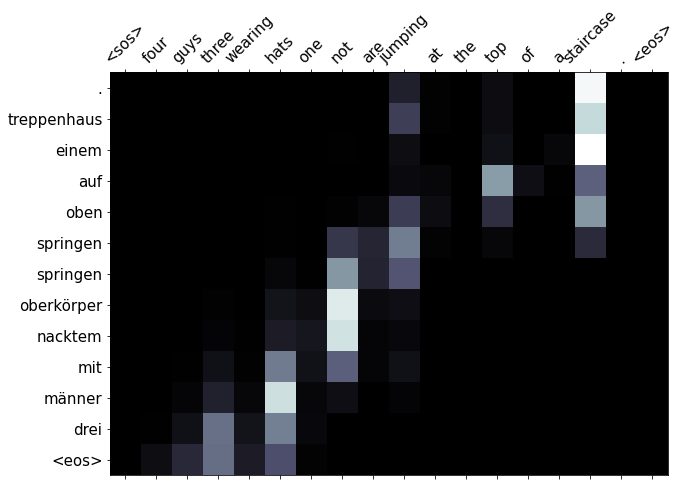

In [101]:
translate_and_display_attention(11)

src: $['a', 'dog', 'is', 'playing', 'with', 'a', 'hose', '.']
trg: $['.', 'schlauch', 'einem', 'mit', 'spielt', 'hund', 'ein']
predicted: ['.', 'schlauch', 'einem', 'mit', 'spielt', 'hund', 'ein', '<eos>']


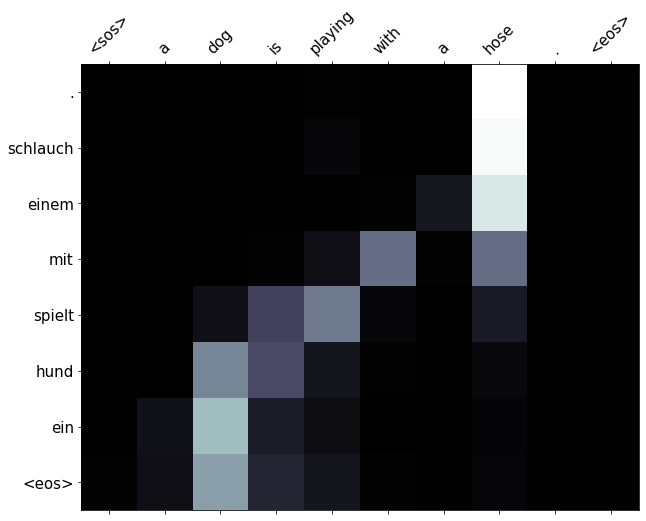

In [102]:
translate_and_display_attention(66)

In [103]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

  trgs = []
  pred_trgs = []

  for datum in data:

    src = vars(datum)['src']
    trg = vars(datum)['trg']

    pred_trg, _ = translate_sentence(src, SRC, TRG, model, device, max_len)

    pred_trg = pred_trg[:-1]

    pred_trgs.append(pred_trg)
    trgs.append([trg])

  return bleu_score(pred_trgs, trgs)

In [104]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 26.83
